In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [5]:
from zipfile import ZipFile
file_name = "chest-ctscan-images.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 0s 0us/step


In [7]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(units=4, activation='softmax')(x)
model = Model(InceptionV3_model.input, output)


model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [8]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
#no flip and zoom for test datase

In [10]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/content/chest-ctscan-images/Data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [13]:
# Make sure you provide the same target size as initialied for the image size
test_set = train_datagen.flow_from_directory('/content/chest-ctscan-images/Data/test',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [15]:
# Make sure you provide the same target size as initialied for the image size
valid_set = train_datagen.flow_from_directory('/content/chest-ctscan-images/Data/valid',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 44 images belonging to 4 classes.


In [22]:
import tensorflow as tf
import keras.losses

optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=optimizer1, loss=keras.losses.CategoricalCrossentropy())

In [23]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=8,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-23-da577ed6f055>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/8
2/2 [==============================] - 25s 16s/step - loss: 1.8795 - val_loss: 1.6233
Epoch 2/8
2/2 [==============================] - 10s 8s/step - loss: 2.2480 - val_loss: 1.9963
Epoch 3/8
2/2 [==============================] - 11s 8s/step - loss: 1.8409 - val_loss: 1.1767
Epoch 4/8
2/2 [==============================] - 11s 6s/step - loss: 1.1743 - val_loss: 1.3410
Epoch 5/8
2/2 [==============================] - 15s 13s/step - loss: 0.9929 - val_loss: 0.9797
Epoch 6/8
2/2 [==============================] - 10s 7s/step - loss: 0.7882 - val_loss: 1.0039
Epoch 7/8
2/2 [==============================] - 11s 6s/step - loss: 0.7692 - val_loss: 1.2993
Epoch 8/8
2/2 [==============================] - 11s 9s/step - loss: 0.7150 - val_loss: 1.0003


In [28]:
predictions = model.predict_generator(test_set)
y_pred = np.argmax(predictions, axis=1)
print(y_pred)

<ipython-input-28-0d510219e1f3>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_set)


[3 1 2 2 3 1 2 0 2 3 0 0 0 0 2 0 0 0 2 0 0 3 0 3 3 0 0 3 0 0 0 3 3 3 2 2 0
 2 0 3 2 0 3 2]


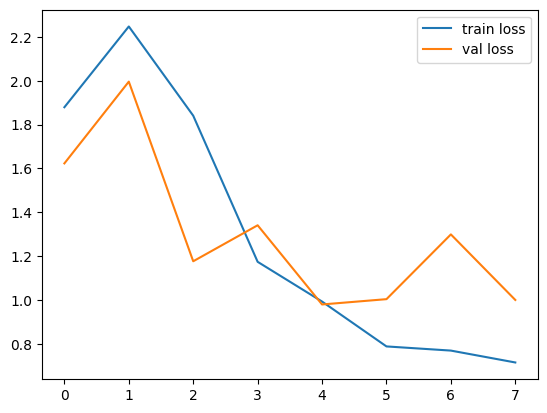

<Figure size 640x480 with 0 Axes>

In [29]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')


In [25]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)
y_pred

NameError: name 'y_pred' is not defined